# Expedia Case Study

Assumptions:
- a search appearing in this list means that the user expressed some form of interest in this hotel (presumably by clicking on it in the search results)

Import some libraries that will be useful for plotting and analysing the data.

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr

In [85]:
df = pd.read_csv('case_study_data.csv', delimiter=',', encoding="utf-8-sig")

# Clean the Data

First let's take a look at a summary of the data

In [86]:
df.describe()

,search_date,arrival,departure,num_adults,num_children,search_id,hotel_id,hotel_price,is_promo,hotel_feature_1,hotel_feature_2,hotel_feature_3,hotel_feature_4,hotel_feature_5,booked
count,46647.000000,46647.000000,46647.000000,46647.000000,46647.000000,46647.000000,46647.000000,46647.000000,46647.000000,45445.000000,46322.000000,46647.000000,46647.000000,46647.000000,46647.000000
mean,11.734517,126.788046,134.479902,2.370570,0.812335,5509.648659,23095.564302,2599.055621,0.501490,76.849742,63.108847,59.068729,5.982335,2.357601,0.006603
std,7.336887,90.867556,92.517336,0.912667,0.949223,4460.689701,13480.392766,4490.091588,0.500003,41.747830,22.846125,51.378153,6.014773,1.811249,0.080990
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,30.370000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,49.000000,54.000000,2.000000,0.000000,1656.000000,11474.000000,559.400000,0.000000,46.238512,52.000000,16.000000,1.000000,1.000000,0.000000
50%,12.000000,109.000000,116.000000,2.000000,0.000000,4488.000000,23309.000000,1336.600000,1.000000,67.712628,52.000000,46.000000,4.000000,1.000000,0.000000
75%,17.000000,187.000000,197.000000,3.000000,2.000000,8727.000000,33668.000000,3090.510000,1.000000,128.117134,90.000000,86.000000,9.000000,4.000000,0.000000
max,25.000000,493.000000,501.000000,8.000000,6.000000,16015.000000,46647.000000,175454.410000,1.000000,143.777606,100.000000,287.000000,36.000000,7.000000,1.000000


We can see from the count of each column that 'hotel_feature_1' and 'hotel_feature_2' are missing values.

### Missing Data

In [87]:
print "Number of missing hotel_feature_1 entries: " + str(len(df[np.isnan(df['hotel_feature_1'])]))
print "Number of missing hotel_feature_2 entries: " + str(len(df[np.isnan(df['hotel_feature_2'])]))

Number of missing hotel_feature_1 entries: 1202
Number of missing hotel_feature_2 entries: 325


We can drop these values from the dataset.

In [88]:
df = df[np.isnan(df['hotel_feature_1']) != True]
df = df[np.isnan(df['hotel_feature_2']) != True]

*** Continue Cleaning By Checking The Range of the Numbers and Stating Assumptions e.g.
- if the arrival date reads 457 then that is a book for next year

# New Columns

We can now add some more columns to our dataset that we might find useful.

In [91]:
df['stay_length'] = df['departure'] - df['arrival']

In [92]:
df['price_per_night'] = df['hotel_price'] / df['stay_length']

In [93]:
df.round({'price_per_night': 2}).head()

,search_date,arrival,departure,num_adults,num_children,search_id,hotel_id,hotel_price,is_promo,hotel_feature_1,hotel_feature_2,hotel_feature_3,hotel_feature_4,hotel_feature_5,booked,stay_length,price_per_night
0,25,457,471,3,2,0,517,1724.38,0,64.490309,85.0,7,0,0,0,14,123.17
1,25,457,471,3,2,0,517,1724.38,0,64.490309,85.0,7,0,0,0,14,123.17
2,25,457,471,3,2,0,29771,1905.54,1,25.826343,52.0,13,1,1,0,14,136.11
3,25,458,463,2,0,1,517,2077.95,0,64.490309,85.0,9,0,0,0,5,415.59
4,25,458,463,2,0,1,40744,6822.10,0,24.959968,52.0,11,1,2,0,5,1364.42


To help with our correlation analysis later on, we can add a column that categorises the hotel price per night.

In [161]:
df.sort_values('price_per_night').head()

,search_date,arrival,departure,num_adults,num_children,search_id,hotel_id,hotel_price,is_promo,hotel_feature_1,hotel_feature_2,hotel_feature_3,hotel_feature_4,hotel_feature_5,booked,stay_length,price_per_night,price_category
3804,17,55,56,2,0,291,10533,30.37,1,139.316187,80.0,72,1,4,0,1,30.370000,NaN
26626,17,39,41,2,1,5594,10533,60.74,1,139.316187,80.0,76,1,4,0,2,30.370000,NaN
45268,2,26,41,2,0,14879,10533,491.77,1,139.316187,80.0,49,1,4,0,15,32.784667,1.0
45181,4,9,26,2,0,14804,10533,562.02,1,139.316187,80.0,34,1,4,0,17,33.060000,1.0
26621,17,22,28,2,2,5592,10533,202.46,1,139.316187,80.0,71,1,4,0,6,33.743333,1.0


In [118]:
bins = pd.qcut(df['price_per_night'], 6, retbins=True, labels=False)[1]

In [123]:
group_names = [1, 2, 3, 4, 5, 6]

In [124]:
df['price_category'] = pd.cut(df['price_per_night'], bins, labels=group_names)

In [125]:
df.head()

,search_date,arrival,departure,num_adults,num_children,search_id,hotel_id,hotel_price,is_promo,hotel_feature_1,hotel_feature_2,hotel_feature_3,hotel_feature_4,hotel_feature_5,booked,stay_length,price_per_night,price_category
0,25,457,471,3,2,0,517,1724.38,0,64.490309,85.0,7,0,0,0,14,123.17,2
1,25,457,471,3,2,0,517,1724.38,0,64.490309,85.0,7,0,0,0,14,123.17,2
2,25,457,471,3,2,0,29771,1905.54,1,25.826343,52.0,13,1,1,0,14,136.11,3
3,25,458,463,2,0,1,517,2077.95,0,64.490309,85.0,9,0,0,0,5,415.59,5
4,25,458,463,2,0,1,40744,6822.10,0,24.959968,52.0,11,1,2,0,5,1364.42,6


Now we have cleaned the data and added some useful columns to the data set we can now have a look at the data by plotting it.

# Plotting The Data

In [94]:
import seaborn as sb
%matplotlib inline

#### Arrival and Departure Dates

First let's plot the arrival and departure dates together

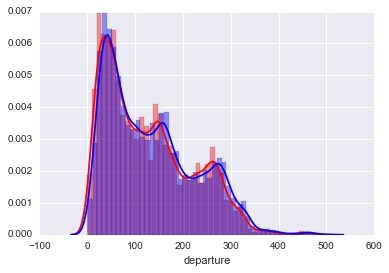

In [95]:
fig, ax = plt.subplots()
sb.distplot(df['arrival'], ax=ax, color='r')
sb.distplot(df['departure'], ax=ax, color='b')

plt.savefig("arrival_departure.png")

From this we can clearly see 'spikes' in the data that signify the popular dates to book a holiday.

#### Length of Stay

Next, let's look at the distribution of the length of stays.

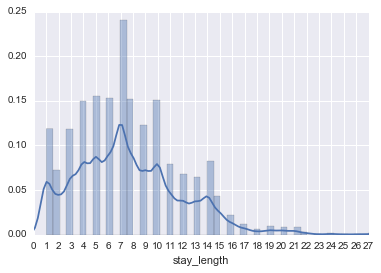

In [96]:
plt.xlim(0, 27)
plt.xticks(np.arange(0, 28, 1.0))
sb.distplot(df['stay_length'])
plt.savefig("stay_length.png")

Again, we can clearly see that (predictably) the most popular length of stay is 1 week.

#### Number of Adults and Children

Now we will look at the distribution of searches containing different numbers of adults and children

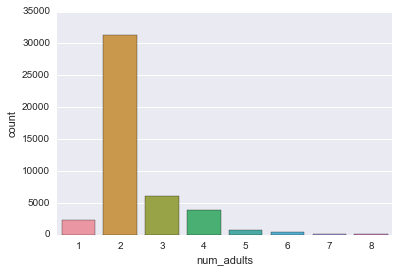

In [98]:
sb.countplot(x="num_adults", data=df)
plt.savefig("num_adults.png")

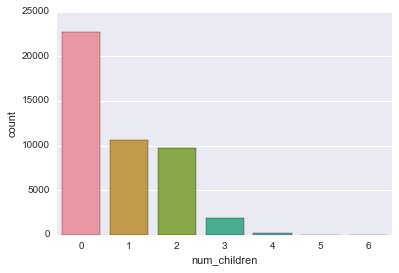

In [99]:
sb.countplot(x="num_children", data=df)
plt.savefig("num_children.png")

These plots show us that most hotel searches are being made for 2 adults, with no children.

** Insert Scattler Plot of Adults -> Kids **

#### Number of Hotels

In [162]:
print "The number of unique hotels in our dataset is " + str(len(df['hotel_id'].unique()))

The number of unique hotels in our dataset is 343


#### Ratio of Promo

In [163]:
num_promo = len(df[df['is_promo'] == 1])
total_searches = len(df)
print "The ratio of hotels offering a promotion in the dataset is " + str(round((num_promo / float(total_searches)), 2))

The ratio of hotels offering a promotion in the dataset is 0.51


### Hotel Features

We can now look at the distribution of the different features for the hotels.

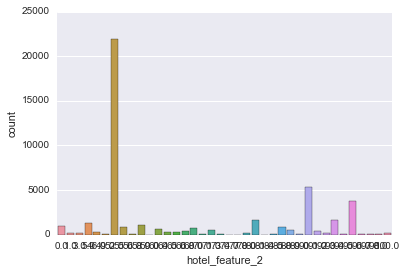

In [144]:
sb.countplot(x="hotel_feature_2", data=df)
plt.savefig("hotel_feature_2.png")

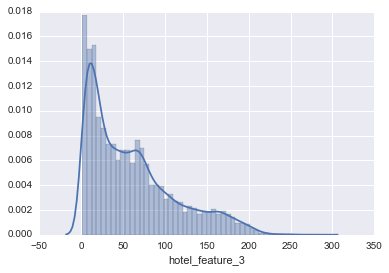

In [103]:
sb.distplot(df['hotel_feature_3'])
plt.savefig("hotel_feature_3.png")

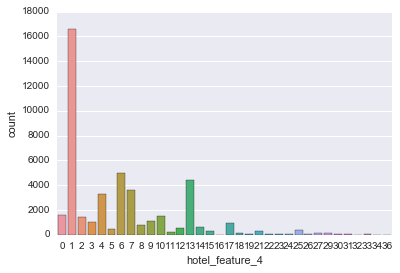

In [104]:
sb.countplot(x="hotel_feature_4", data=df)
plt.savefig("hotel_feature_4.png")

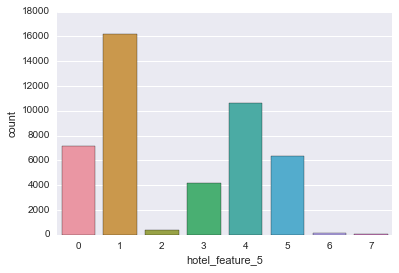

In [105]:
sb.countplot(x="hotel_feature_5", data=df)
plt.savefig("hotel_feature_5.png")

# Correlations Between Columns

### Correlation Matrix

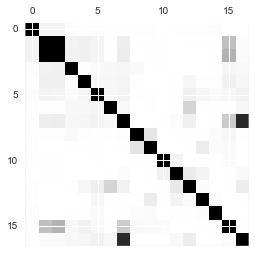

In [106]:
plt.matshow(df.corr(), interpolation='none', vmin=0, vmax=1)
plt.savefig("correlation_matrix.png")

### Correlations I Will Explore

I think the following correlations would be interesting to explore:
- price_per_night -> hotel_feature_1
- price_per_night -> hotel_feature_2
- price_per_night -> hotel_feature_3
- price_per_night -> hotel_feature_4
- price_per_night -> hotel_feature_5
- number_of_searches -> booked
- is_promo -> booked
- price_per_night -> booked
- number_children -> hotel_feature_1
- number_children -> hotel_feature_2
- number_children -> hotel_feature_3
- number_children -> hotel_feature_4
- number_children -> hotel_feature_5

In [107]:
corr_pairs = [['price_per_night', 'hotel_feature_1'], 
              ['price_per_night', 'hotel_feature_2'], 
              ['price_per_night', 'hotel_feature_3'], 
              ['price_per_night', 'hotel_feature_4'],
              ['price_per_night', 'hotel_feature_5'],
              ['num_children', 'hotel_feature_1'],
              ['num_children', 'hotel_feature_2'],
              ['num_children', 'hotel_feature_3'],
              ['num_children', 'hotel_feature_4'],
              ['num_children', 'hotel_feature_5'],
              ['num_adults', 'hotel_feature_1'],
              ['num_adults', 'hotel_feature_2'],
              ['num_adults', 'hotel_feature_3'],
              ['num_adults', 'hotel_feature_4'],
              ['num_adults', 'hotel_feature_5'],
             ]

We can now look at the statistical significance of the pearson correlation between these parameters.

In [108]:
for pair in corr_pairs:
    print "The correlation for " + pair[0] + " & " + pair[1] + " is: "
    print str(pearsonr(df[pair[0]], df[pair[1]]))
    print ""

The correlation for price_per_night & hotel_feature_1 is: 
(-0.1416896479642599, 5.4027886280529437e-201)

The correlation for price_per_night & hotel_feature_2 is: 
(-0.028421950788344568, 1.55753731736103e-09)

The correlation for price_per_night & hotel_feature_3 is: 
(0.044385324809133452, 4.0049752195731767e-21)

The correlation for price_per_night & hotel_feature_4 is: 
(0.14022619320021484, 7.2630881743440273e-197)

The correlation for price_per_night & hotel_feature_5 is: 
(-0.039001291437989694, 1.1577949731445183e-16)

The correlation for num_children & hotel_feature_1 is: 
(-0.11668571735346239, 1.568906813480986e-136)

The correlation for num_children & hotel_feature_2 is: 
(-0.00082246088750252233, 0.86131696846304773)

The correlation for num_children & hotel_feature_3 is: 
(-0.1068750232195118, 9.8673819796732317e-115)

The correlation for num_children & hotel_feature_4 is: 
(0.072785751712647673, 4.671144161736554e-54)

The correlation for num_children & hotel_feature_5

As we can see from the correlation coefficient, there is no strong correlation between any of these pairs.

## Promo Code Leads to a Greater Chance of Booking

We can now determine if there is any correlation between a search result having a promo code, and that search resulting in a booking.

In [109]:
num_promo = len(df[df['is_promo'] == 1])
num_not_promo = len(df[df['is_promo'] == 0])

num_promo_booked = len(df[(df['booked'] == 1) & (df['is_promo'] == 1)]) 
num_not_promo_booked = len(df[(df['booked'] == 1) & (df['is_promo'] == 0)]) 

print "Promoed in the booked population: " + str((num_promo_booked) / float(num_promo))
print "Promoed in the not booked population: " + str(num_not_promo_booked / float(num_not_promo))

Promoed in the booked population: 0.00828335993787
Promoed in the not booked population: 0.00487671482612


In [110]:
obs = np.array([[num_promo-num_promo_booked, num_promo_booked], [num_not_promo-num_not_promo_booked, num_not_promo_booked]])
chi2, p, dof, expected = stats.chi2_contingency(obs)
print str(p)

1.08424636409e-05


As we can see from this p-value, there is a statistically significant correlation between a search result having a promo code and that search resulting in a booking.

## Investigating Price Category and Booking Conversion

We can now investigate if there is a correlation between a 'price_category' and converting to a booking.

In [148]:
def count_and_booked(category):
    num_booked = len(df[(df['booked'] == 1) & (df['price_category'] == category)])
    num = len(df[df['price_category'] == category])
    return (num_booked, num)

In [149]:
for i in [x  for x in range(1, 7)]:
    num_booked, num = count_and_booked(i)
    print "Percentage for " + str(i) + " is: " + str(num_booked/float(num))

Percentage for 1 is: 0.00889537971322
Percentage for 2 is: 0.00639403223658
Percentage for 3 is: 0.00718180609124
Percentage for 4 is: 0.00691489361702
Percentage for 5 is: 0.00625
Percentage for 6 is: 0.00412234042553


In [157]:
def get_chi_pvalue(num, num_booked):
    obs = np.array([[num-num_booked, num_booked], [len(df)-num, len(df[df['booked'] == 1])-num_booked]])
    chi2, p, dof, expected = stats.chi2_contingency(obs)
    return p

In [159]:
for i in [x  for x in range(1, 7)]:
    num_booked, num = count_and_booked(i)
    print "Percentage for " + str(i) + " is: " + str(get_chi_pvalue(num, num_booked))

Percentage for 1 is: 0.0086406285599
Percentage for 2 is: 0.879367946384
Percentage for 3 is: 0.538446554711
Percentage for 4 is: 0.762355643353
Percentage for 5 is: 0.748283222141
Percentage for 6 is: 0.0048746074753


From these results we can see that.